In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from numpy.linalg import solve
import csv
import glob
import os

path = "/root/notebooks/ALS/nf_data"
rating_files = glob.glob(os.path.join(path, "training_set/mv_*.txt"))

rating_header = ["CustomerID", "Rating", "Date", "MovieID"]

list_ = []
for f in rating_files:
    index = int(f[44:51])
    df = pd.read_csv(f, sep=",", header=None, skiprows=1, names=rating_header)
    df["MovieID"] = index
    list_.append(df)
    
ratings_df = pd.concat(list_)

print(ratings_df.head(10))

   CustomerID  Rating        Date  MovieID
0     2385003       4  2004-07-08    10958
1     2625420       2  2004-06-03    10958
2     1508073       4  2004-12-02    10958
3      345673       4  2005-08-10    10958
4     1701976       4  2005-08-25    10958
5      970031       3  2004-03-31    10958
6     1826086       4  2004-11-08    10958
7     1426869       5  2005-04-26    10958
8     2175560       3  2001-04-10    10958
9     2604455       3  2004-10-09    10958


In [2]:
movies_file = glob.glob(os.path.join(path, "movie_titles.txt"))

movies_header = ["MovieID", "YearOfRelease", "Title"]

movies_df = pd.read_csv(movies_file[0], sep=",", header=None, names=movies_header, encoding="latin-1")

print(movies_df.head(10))

   MovieID  YearOfRelease                         Title
0        1         2003.0               Dinosaur Planet
1        2         2004.0    Isle of Man TT 2004 Review
2        3         1997.0                     Character
3        4         1994.0  Paula Abdul's Get Up & Dance
4        5         2004.0      The Rise and Fall of ECW
5        6         1997.0                          Sick
6        7         1992.0                         8 Man
7        8         2004.0    What the #$*! Do We Know!?
8        9         1991.0      Class of Nuke 'Em High 2
9       10         2001.0                       Fighter


In [3]:
n_users = ratings_df.CustomerID.unique().shape[0]
n_items = ratings_df.MovieID.unique().shape[0]

#CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
customers_dict = dict(zip(ratings_df.CustomerID.unique(), range(ratings_df.CustomerID.unique().shape[0])))

In [4]:
ratings = np.zeros((n_users, n_items))
for row in ratings_df.itertuples():
    ratings[customers_dict[row[1]]-1, row[4]-1] = row[2]
print(ratings.shape)

(480189, 17770)


In [5]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))

Sparsity: 1.18%


In [6]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=1, 
                                        replace=False)
        
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Confirm test and training are disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

In [7]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [8]:
class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print("\tcurrent iteration: {}".format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print("Iteration: {}".format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print("Train mse: " + str(self.train_mse[-1]))
                print("Test mse: " + str(self.test_mse[-1]))
            iter_diff = n_iter

In [9]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 4, 8, 16, 32]
MF_ALS.calculate_learning_curve(iter_array, test)

In [10]:
%matplotlib inline
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.test_mse, label='Test', linewidth=5)
    plt.plot(iter_array, model.train_mse, label='Training', linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

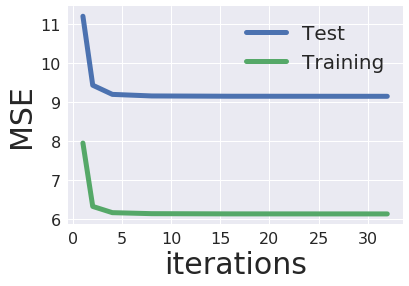

In [11]:
plot_learning_curve(iter_array, MF_ALS)